/var/folders/_9/3m6hqqld0kx76783x498xxq80000gn/T/ipykernel_90620/1784904517.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_file, delim_whitespace=True)


Data Preview:
    Time[s]    8_V[V]    8_I[A]    9_V[V]  9_I[A]   10_V[V]  10_I[A]  \
0  0.012305  0.773750 -0.000135  0.446797     NaN -0.556094      NaN   
1  0.024582  0.836328 -0.000141  0.136719     NaN -0.139453      NaN   
2  0.035359  0.873516 -0.000148  0.144375     NaN -0.072266      NaN   
3  0.059642  0.909219 -0.000155  0.149687     NaN  0.019141      NaN   
4  0.070857  0.943359 -0.000160  0.153984     NaN  0.044766      NaN   

    11_V[V]  11_I[A]   12_V[V]  ...   19_V[V]  19_I[A]   20_V[V]  20_I[A]  \
0 -0.388906      NaN -0.580547  ... -0.246719      NaN -0.079531      NaN   
1  0.043516      NaN -0.160859  ... -0.081484      NaN  0.009609      NaN   
2  0.043984      NaN -0.082500  ...  0.027188      NaN  0.010469      NaN   
3  0.045859      NaN  0.012812  ...  0.045000      NaN  0.011094      NaN   
4  0.046172      NaN  0.045391  ...  0.044531      NaN  0.011719      NaN   

    21_V[V]  21_I[A]   22_V[V]  22_I[A]   23_V[V]  23_I[A]  
0  0.015078      NaN  0.05578

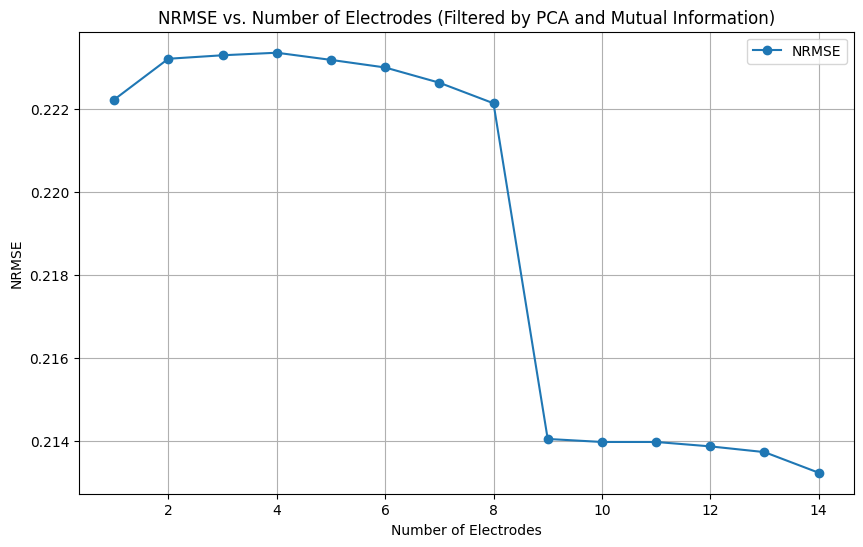

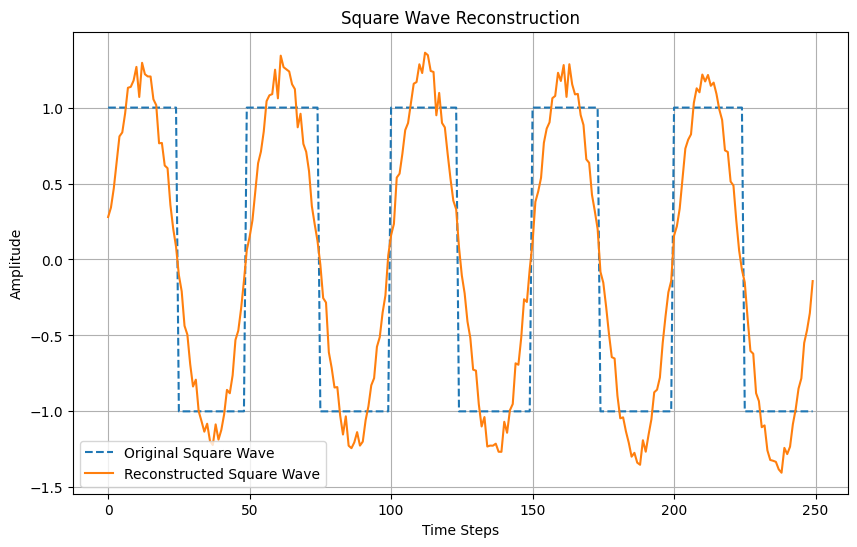

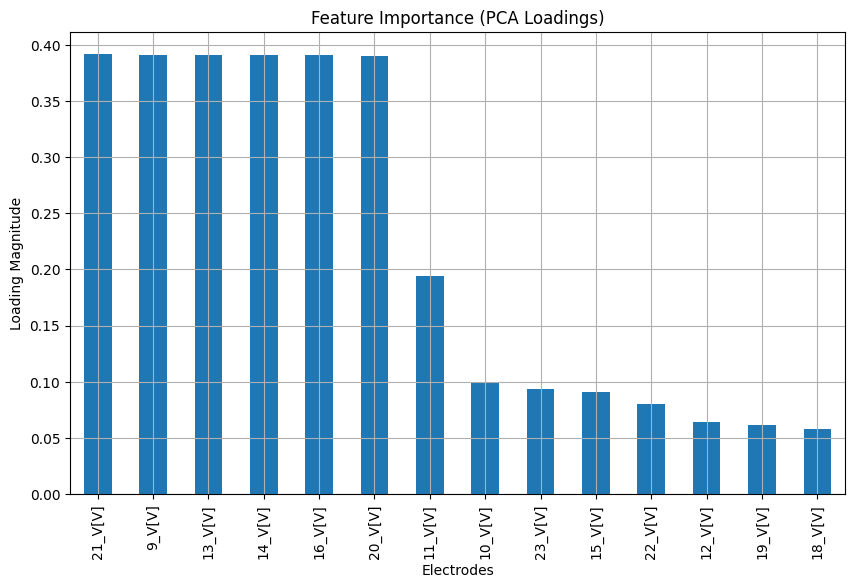

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from itertools import combinations

# Load the data
data_file = '/Users/davidepilati/Library/CloudStorage/OneDrive-PolitecnicodiTorino/PhD/Misure/InrimARC/NWN_Pad235D/006_INRiMJanis_NWN_Pad235D_gridSE_Custom Wave Measurement_2025_02_10.txt'
data = pd.read_csv(data_file, delim_whitespace=True)

# Display the first few rows of the data to understand its structure
print("Data Preview:")
print(data.head())

# Step 1: Data Preprocessing
voltage_columns = [col for col in data.columns if 'V' in col]
data_voltage = data[voltage_columns + ['Time[s]']][151:401]

# Remove columns with zero variance (linearly dependent signals)
zero_variance_columns = data_voltage.loc[:, data_voltage.var() == 0].columns.tolist()
print(f"Removing zero-variance columns: {zero_variance_columns}")
data_voltage = data_voltage.drop(columns=zero_variance_columns)

# Handle NaN values by using a SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')
processed_data = pd.DataFrame(imputer.fit_transform(data_voltage), columns=data_voltage.columns)

# Standardize the features for feature selection
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(processed_data), columns=data_voltage.columns)

# Step 2: PCA for Feature Importance
X = scaled_data.drop(columns=['Time[s]','8_V[V]', '17_V[V]'])
y = np.sin(processed_data['8_V[V]'] - np.mean(processed_data['8_V[V]']))  # Sine wave as target
time = processed_data['Time[s]']
pca = PCA()
X_pca = pca.fit_transform(X)
pca_loadings = pd.Series(np.abs(pca.components_[0]), index=X.columns).sort_values(ascending=False)

# Step 3: Electrode Elimination Based on Mutual Information
threshold = 6  # Set a threshold for mutual information
remaining_electrodes = pca_loadings.index.tolist()
final_electrodes = []
to_remove_all = []
while remaining_electrodes:
    # Select the most important electrode
    current_electrode = remaining_electrodes.pop(0)
    final_electrodes.append(current_electrode)
    
    # Compare with remaining electrodes using mutual information
    to_remove = []
    for other_electrode in remaining_electrodes:
        mi_score = mutual_info_regression(
            X[[current_electrode]], X[other_electrode]
        )[0]
        if mi_score > threshold:
            to_remove.append(other_electrode)
            to_remove_all.append(other_electrode)
    print(f'electrodes removed:{to_remove}')
    # Remove electrodes with high mutual information
    remaining_electrodes = [e for e in remaining_electrodes if e not in to_remove]

print("Final selected electrodes:", final_electrodes)

# Step 4: Ridge Regression for Reconstruction and Evaluation
X_filtered = X[final_electrodes]
y_square = np.sign(y)  # Generate square wave target

ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5).fit(X_filtered, y_square)
y_pred = ridge.predict(X_filtered)

# Evaluate the reconstruction performance
r2 = r2_score(y_square, y_pred)
nrmse = np.sqrt(mean_squared_error(y_square, y_pred)) / (np.max(y_square) - np.min(y_square))
print(f"Reconstruction R^2 Score: {r2}")
print(f"Reconstruction NRMSE: {nrmse}")

# Step 5: NRMSE as a Function of Number of Electrodes (Sorted by PCA Loadings)
nrmse_values = []

for i in range(1, len(final_electrodes) + 1):
    selected_electrodes = final_electrodes[:i]
    X_subset = X[selected_electrodes]
    ridge_subset = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_subset, y_square)
    y_pred_subset = ridge_subset.predict(X_subset)
    nrmse = np.sqrt(mean_squared_error(y_square, y_pred_subset)) / (np.max(y_square) - np.min(y_square))
    nrmse_values.append(nrmse)

# Plot NRMSE as a Function of Number of Electrodes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(final_electrodes) + 1), nrmse_values, marker='o', linestyle='-', label='NRMSE')
plt.xlabel('Number of Electrodes')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Number of Electrodes (Filtered by PCA and Mutual Information)')
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Visualization
# Plot the original and reconstructed square wave
plt.figure(figsize=(10, 6))

plt.plot(y_square[:500], label='Original Square Wave', linestyle='--')  # Plot a subset for clarity
plt.plot(y_pred[:500], label='Reconstructed Square Wave')
plt.legend()
plt.title('Square Wave Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot PCA Loadings
plt.figure(figsize=(10, 6))
pca_loadings.sort_values(ascending=False).plot(kind='bar', title='Feature Importance (PCA Loadings)')
plt.xlabel('Electrodes')
plt.ylabel('Loading Magnitude')
plt.grid(True)
plt.show()


/var/folders/_9/3m6hqqld0kx76783x498xxq80000gn/T/ipykernel_51802/1401623374.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(data_file, delim_whitespace=True)


Data Preview:
    Time[s]    8_V[V]    8_I[A]    9_V[V]  9_I[A]   10_V[V]  10_I[A]  \
0  0.012305  0.773750 -0.000135  0.446797     NaN -0.556094      NaN   
1  0.024582  0.836328 -0.000141  0.136719     NaN -0.139453      NaN   
2  0.035359  0.873516 -0.000148  0.144375     NaN -0.072266      NaN   
3  0.059642  0.909219 -0.000155  0.149687     NaN  0.019141      NaN   
4  0.070857  0.943359 -0.000160  0.153984     NaN  0.044766      NaN   

    11_V[V]  11_I[A]   12_V[V]  ...   19_V[V]  19_I[A]   20_V[V]  20_I[A]  \
0 -0.388906      NaN -0.580547  ... -0.246719      NaN -0.079531      NaN   
1  0.043516      NaN -0.160859  ... -0.081484      NaN  0.009609      NaN   
2  0.043984      NaN -0.082500  ...  0.027188      NaN  0.010469      NaN   
3  0.045859      NaN  0.012812  ...  0.045000      NaN  0.011094      NaN   
4  0.046172      NaN  0.045391  ...  0.044531      NaN  0.011719      NaN   

    21_V[V]  21_I[A]   22_V[V]  22_I[A]   23_V[V]  23_I[A]  
0  0.015078      NaN  0.05578

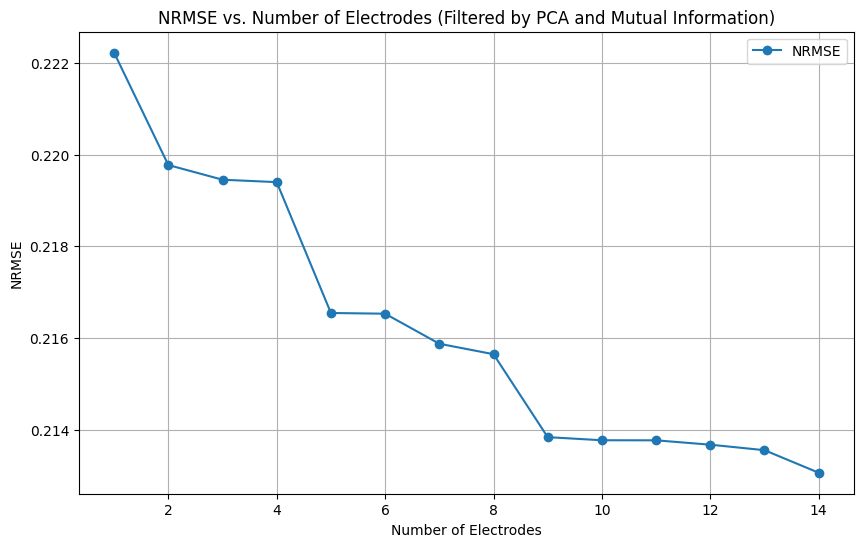

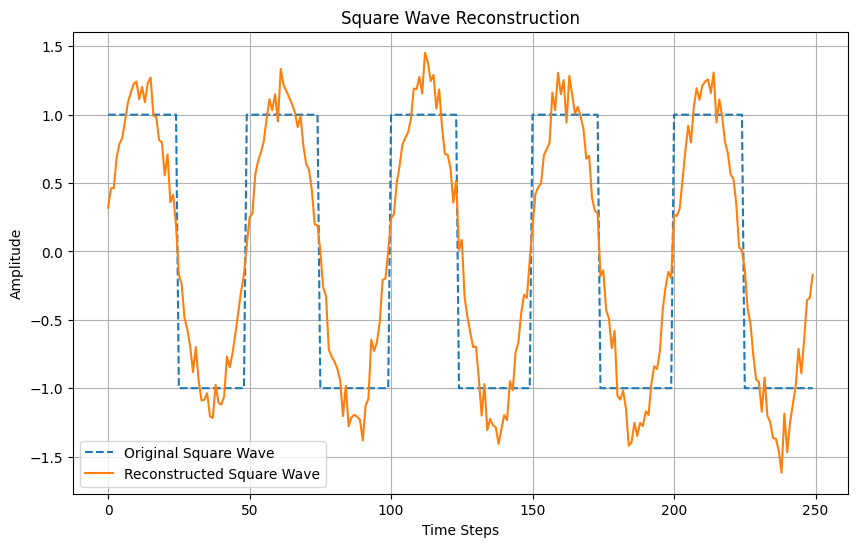

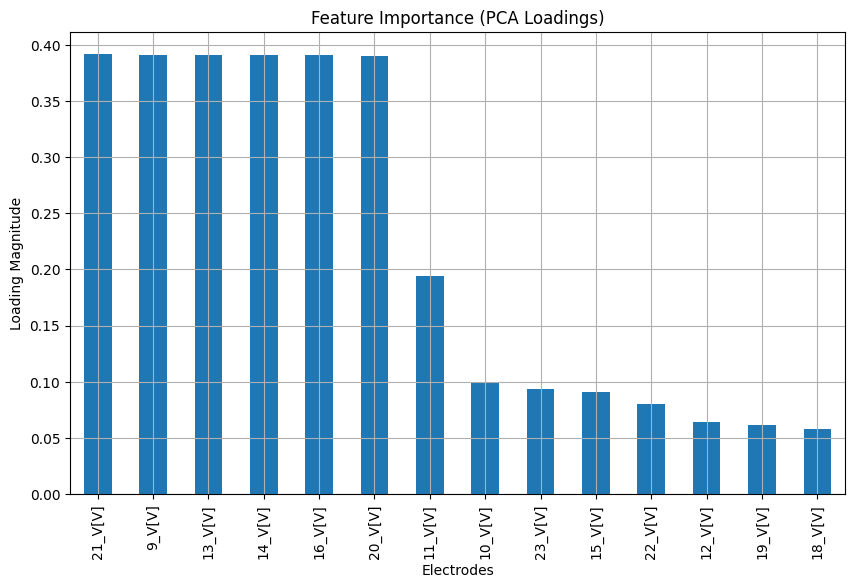

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from itertools import combinations

# Load the data
data_file = '/Users/davidepilati/Library/CloudStorage/OneDrive-PolitecnicodiTorino/PhD/Misure/InrimARC/NWN_Pad235D/006_INRiMJanis_NWN_Pad235D_gridSE_Custom Wave Measurement_2025_02_10.txt'
data = pd.read_csv(data_file, delim_whitespace=True)

# Display the first few rows of the data to understand its structure
print("Data Preview:")
print(data.head())

# Step 1: Data Preprocessing
voltage_columns = [col for col in data.columns if 'V' in col]
data_voltage = data[voltage_columns + ['Time[s]']][151:401]

# Remove columns with zero variance (linearly dependent signals)
zero_variance_columns = data_voltage.loc[:, data_voltage.var() == 0].columns.tolist()
print(f"Removing zero-variance columns: {zero_variance_columns}")
data_voltage = data_voltage.drop(columns=zero_variance_columns)

# Handle NaN values by using a SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')
processed_data = pd.DataFrame(imputer.fit_transform(data_voltage), columns=data_voltage.columns)

# Standardize the features for feature selection
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(processed_data), columns=data_voltage.columns)

# Step 2: PCA for Feature Importance
X = scaled_data.drop(columns=['Time[s]', '8_V[V]', '17_V[V]'])
y = np.sin(processed_data['8_V[V]'] - np.mean(processed_data['8_V[V]']))  # Sine wave as target
time = processed_data['Time[s]']
pca = PCA()
X_pca = pca.fit_transform(X)
pca_loadings = pd.Series(np.abs(pca.components_[0]), index=X.columns).sort_values(ascending=False)

# Step 3: Electrode Elimination Based on Mutual Information
threshold = 6  # Set a threshold for mutual information
remaining_electrodes = pca_loadings.index.tolist()
final_electrodes = []
to_remove_all = []
while remaining_electrodes:
    # Select the most important electrode
    current_electrode = remaining_electrodes.pop(0)
    final_electrodes.append(current_electrode)
    
    # Compare with remaining electrodes using mutual information
    to_remove = []
    for other_electrode in remaining_electrodes:
        mi_score = mutual_info_regression(
            X[[current_electrode]], X[other_electrode]
        )[0]
        if mi_score > threshold:
            to_remove.append(other_electrode)
            to_remove_all.append(other_electrode)
    print(f'electrodes removed: {to_remove}')
    # Remove electrodes with high mutual information
    remaining_electrodes = [e for e in remaining_electrodes if e not in to_remove]

print("Final selected electrodes:", final_electrodes)

# Step 4: Linear Regression for Reconstruction and Evaluation
X_filtered = X[final_electrodes]
y_square = np.sign(y)  # Generate square wave target

lin_reg = LinearRegression().fit(X_filtered, y_square)
y_pred = lin_reg.predict(X_filtered)

# Evaluate the reconstruction performance
r2 = r2_score(y_square, y_pred)
nrmse = np.sqrt(mean_squared_error(y_square, y_pred)) / (np.max(y_square) - np.min(y_square))
print(f"Reconstruction R^2 Score: {r2}")
print(f"Reconstruction NRMSE: {nrmse}")

# Step 5: NRMSE as a Function of Number of Electrodes (Sorted by PCA Loadings)
nrmse_values = []

for i in range(1, len(final_electrodes) + 1):
    selected_electrodes = final_electrodes[:i]
    X_subset = X[selected_electrodes]
    lin_reg_subset = LinearRegression().fit(X_subset, y_square)
    y_pred_subset = lin_reg_subset.predict(X_subset)
    nrmse = np.sqrt(mean_squared_error(y_square, y_pred_subset)) / (np.max(y_square) - np.min(y_square))
    nrmse_values.append(nrmse)

# Plot NRMSE as a Function of Number of Electrodes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(final_electrodes) + 1), nrmse_values, marker='o', linestyle='-', label='NRMSE')
plt.xlabel('Number of Electrodes')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Number of Electrodes (Filtered by PCA and Mutual Information)')
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Visualization
# Plot the original and reconstructed square wave
plt.figure(figsize=(10, 6))
plt.plot(y_square[:500], label='Original Square Wave', linestyle='--')  # Plot a subset for clarity
plt.plot(y_pred[:500], label='Reconstructed Square Wave')
plt.legend()
plt.title('Square Wave Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot PCA Loadings
plt.figure(figsize=(10, 6))
pca_loadings.sort_values(ascending=False).plot(kind='bar', title='Feature Importance (PCA Loadings)')
plt.xlabel('Electrodes')
plt.ylabel('Loading Magnitude')
plt.grid(True)
plt.show()


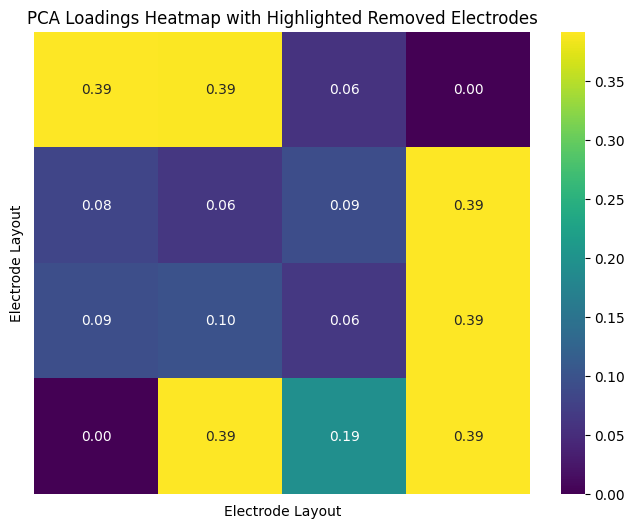

In [26]:
# Step 10: Plot Heatmaps for Mutual Information and PCA Loadings
# Define electrode layout
# Define electrode layout
electrode_layout = np.array([
    [21, 20, 18, 17],
    [22, 19, 15, 16],
    [23, 10, 12, 14],
    [8, 9, 11, 13]
])

pca_heatmap = np.zeros_like(electrode_layout, dtype=float)
for i, row in enumerate(electrode_layout):
    for j, electrode in enumerate(row):
        col_name = f"{electrode}_V[V]"
        if col_name in pca_loadings:
            pca_heatmap[i, j] = pca_loadings[col_name]

# Plot heatmap with red borders for electrodes in `to_remove_all`
plt.figure(figsize=(8, 6))
ax = sns.heatmap(pca_heatmap, annot=True, fmt=".2f", cmap="viridis", xticklabels=False, yticklabels=False, cbar=True)

# Add red borders to removed electrodes
for i, row in enumerate(electrode_layout):
    for j, electrode in enumerate(row):
        col_name = f"{electrode}_V[V]"
        if col_name in to_remove_all:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.title('PCA Loadings Heatmap with Highlighted Removed Electrodes')
plt.xlabel('Electrode Layout')
plt.ylabel('Electrode Layout')
plt.show()

Optimal Threshold: 1.4000000000000001
Optimal NRMSE: 0.21612514280734613
Number of Electrodes Selected: 9


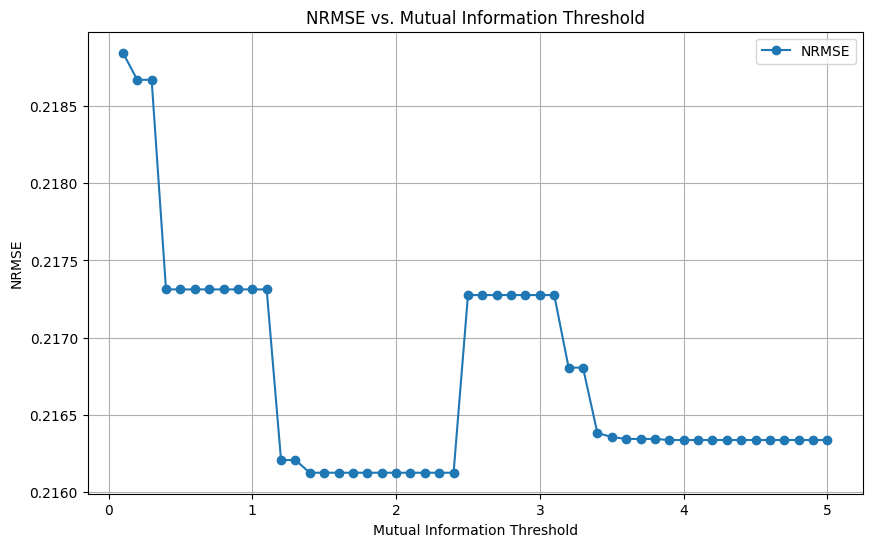

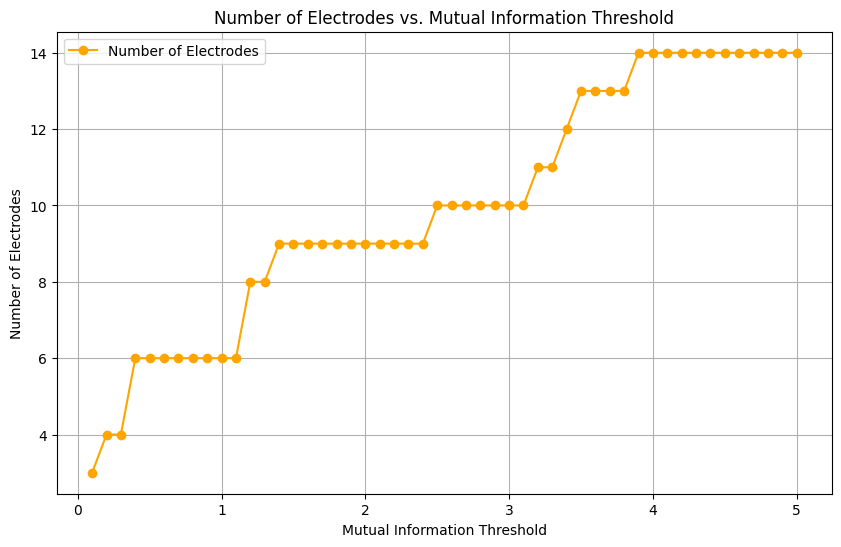

In [27]:

# Step 7: Threshold Optimization for NRMSE
threshold_values = np.linspace(0.1, 5, 50)
optimal_nrmse = float('inf')
optimal_threshold = None
optimal_electrodes = None
nrmse_vs_threshold = []
nrmse_vs_electrodes = []

for threshold in threshold_values:
    remaining_electrodes = pca_loadings.index.tolist()
    filtered_electrodes = []

    while remaining_electrodes:
        current_electrode = remaining_electrodes.pop(0)
        filtered_electrodes.append(current_electrode)
        to_remove = []

        for other_electrode in remaining_electrodes:
            mi_score = mutual_info_regression(
                X[[current_electrode]], X[other_electrode]
            )[0]
            if mi_score > threshold:
                to_remove.append(other_electrode)

        remaining_electrodes = [e for e in remaining_electrodes if e not in to_remove]

    X_filtered_opt = X[filtered_electrodes]
    ridge_opt = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5).fit(X_filtered_opt, y_square)
    y_pred_opt = ridge_opt.predict(X_filtered_opt)
    nrmse_opt = np.sqrt(mean_squared_error(y_square, y_pred_opt)) / (np.max(y_square) - np.min(y_square))

    nrmse_vs_threshold.append(nrmse_opt)
    nrmse_vs_electrodes.append(len(filtered_electrodes))

    if nrmse_opt < optimal_nrmse:
        optimal_nrmse = nrmse_opt
        optimal_threshold = threshold
        optimal_electrodes = filtered_electrodes

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Optimal NRMSE: {optimal_nrmse}")
print(f"Number of Electrodes Selected: {len(optimal_electrodes)}")

# Plot NRMSE vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, nrmse_vs_threshold, marker='o', linestyle='-', label='NRMSE')
plt.xlabel('Mutual Information Threshold')
plt.ylabel('NRMSE')
plt.title('NRMSE vs. Mutual Information Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Plot Number of Electrodes vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, nrmse_vs_electrodes, marker='o', linestyle='-', color='orange', label='Number of Electrodes')
plt.xlabel('Mutual Information Threshold')
plt.ylabel('Number of Electrodes')
plt.title('Number of Electrodes vs. Mutual Information Threshold')
plt.grid(True)
plt.legend()
plt.show()
